The first CNN we trained on the Fashion MNIST-Dataset got up to 91.3% accuracy.
In this experiment we will try to improve the accuracy through expanding the datasets with synthetic images.

In [1]:
import torch
import torchvision.transforms as tt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

At first we download the FashionMNIST-dataset and convert it to Pytroch-Tensors. The FashionMNIST-dataset consists of 60000 images in the train-set and 10000 images in the test-set.

Many Datasets like CIFAR or FashionMNIST can be downloaded via torchvision. A list of all datasets avaiable with torchvision can be obtained here: https://pytorch.org/docs/stable/torchvision/datasets.html Other custome datasets have to be created form csv-files or other data-sources.

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=tt.Compose([tt.ToTensor()]))           
                         
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                              tt.Compose([tt.ToTensor()])) 

print('Images in train-dataset: {}\nImages in test-dataset: {}'.format(len(train_set), len(test_set)))

Images in train-dataset: 60000
Images in test-dataset: 10000


Now we will split the train-dataset into 10 sub-datasets by label.

In [3]:
# this class will be used to create sub-datasets with the data from the grouped datasets
class sub_sets(Dataset):
    def __init__(self, group):
        self.data = group
        self.n_datapoints = len(group)
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n_datapoints
    

# the group dataset function splits the dataset into 10 groups by label    
def group_dataset(dataset):
    images_grouped = [[],[],[],[],[],[],[],[],[],[]]
    for data_point in dataset:
        images_grouped[data_point[1]].append(data_point)
    return images_grouped
    
groups = group_dataset(train_set)

set0, set1, set2, set3, set4, set5, set6, set7, set8, set9 = [sub_sets(groups[x]) for x in range(10)]
sets = [set0, set1, set2, set3, set4, set5, set6, set7, set8, set9]

sub_loaders = [DataLoader(ds, 100, shuffle=True, pin_memory=True) for ds in sets]
train_loader = DataLoader(train_set, 1000, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, 1000, shuffle=True, pin_memory=True)

To confirm if the dataset is balanced or inbalanced, a histogram is created, which shows the number of images per class.

Text(0, 0.5, 'images')

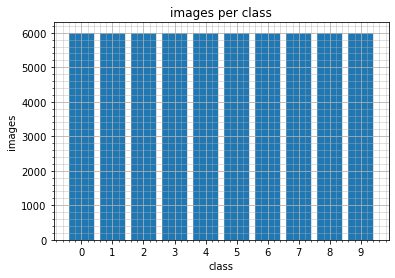

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.bar([a for a in range(10)], height=[len(ds) for ds in sets], label='number of images')
plt.xticks([a for a in range(10)], [a for a in range(10)]) 
ax1.minorticks_on()
ax1.grid(b='True', alpha=0.5, which='minor') 
ax1.grid(alpha=1) 
plt.title('images per class')
ax1.set_xlabel('class')
ax1.set_ylabel('images')

As we can see: The dataset is compleatly balanced.

In [5]:
class D (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(784, 256),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Linear(256, 256),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Linear(256, 1),
        torch.nn.Sigmoid()
        )
    
    def forward(self, images):
        return self.network(images)
    
d0, d1, d2, d3, d4, d5, d6, d7, d8, d9 = [D() for i in range(10)]
d_list = [d0, d1, d2, d3, d4, d5, d6, d7, d8, d9]

In [6]:
class G (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = G = torch.nn.Sequential(
        torch.nn.Linear(64, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 784),
        torch.nn.Tanh()
        )
    
    def forward(self, images):
        return self.network(images)
    
g0, g1, g2, g3, g4, g5, g6, g7, g8, g9 = [G() for i in range(10)]
g_list = [g0, g1, g2, g3, g4, g5, g6, g7, g8, g9]

In [7]:
def to_device(data):                                         
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    if isinstance(data, (list,tuple)):
        return [to_device(x) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():                                            
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
    def __iter__(self):
        for b in self.dataloader: 
            yield to_device(b)

    def __len__(self):
        return len(self.dataloader)
    

sub_loaders = [DeviceDataLoader(loader) for loader in sub_loaders]
g_list = [to_device(g) for g in g_list]
d_list = [to_device(d) for d in d_list]
train_loader = DeviceDataLoader(train_loader)
test_loader = DeviceDataLoader(test_loader)

In [8]:
g_optims = [torch.optim.SGD(g.parameters(), 0.1) for g in g_list]
d_optims = [torch.optim.SGD(d.parameters(), 0.1) for d in d_list]

def d_training(images, g, d, d_optim, g_optim, loss_function=torch.nn.BCELoss()):
  
    batch_size = images.shape[0]
    images = torch.reshape(images, [batch_size, 784])
    targets_real = to_device(torch.ones(batch_size, 1))
    targets_fake = to_device(torch.zeros(batch_size, 1))
    fake_seeds = to_device(torch.randn([batch_size, 64]))
        
    fake_images = g(fake_seeds)
        
    preds_real = d(images)
    preds_fake = d(fake_images)
    
    loss_real = loss_function(preds_real, targets_real)
    loss_fake = loss_function(preds_fake, targets_fake)
    
    batch_loss = loss_real + loss_fake
    
    batch_loss.backward()
    d_optim.step()
    d_optim.zero_grad()
    g_optim.zero_grad()
    
    return batch_loss
  

In [9]:
def g_training(images, g, d, d_optim, g_optim, loss_function=torch.nn.BCELoss()):

    batch_size = images.shape[0]
    targets_real = to_device(torch.ones(batch_size, 1))
    fake_seeds = to_device(torch.randn([batch_size, 64])) 
    fake_images = g(fake_seeds)
    preds = d(fake_images)
        
    batch_loss = loss_function(preds, targets_real)
        
    batch_loss.backward()
    g_optim.step()
    g_optim.zero_grad()
    d_optim.zero_grad()
    
    return batch_loss
    

In [10]:
from torchvision.utils import save_image
from IPython.display import Image, display


def denorm(x):
    o = (x + 1)/2
    return o.clamp(0, 1)


def save_images(images, epoch):
    num_images = images.shape[0]
    images = torch.reshape(images,[num_images, 1, 28, 28])
    save_image(images, r'E:\KI-Models\FashionMNIST_filler_GAN\epoch{}.PNG'.format(epoch), nrow=int(num_images**0.5))

In [11]:
class FashionMNIST_classifier(torch.nn.Module):
    def __init__(self):
        # the following five parameters will be updated, when we train the network.
        
        self.min_loss = 3.4028237 * 10**38                              
        self.max_acc = 0.                        
        self.name = 'FashionMNIST_cnn_no_data_augmentation'
        self.epoch = 0
        self.history = []
        
        super().__init__()
        self.drop = torch.nn.Dropout(0.2)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2)
        
        self.conv_1 = torch.nn.Conv2d(1, 12, 5, padding=(2, 2))
        self.conv_2 = torch.nn.Conv2d(12, 36, 5, padding=(2, 2))
        self.conv_3 = torch.nn.Conv2d(36, 64, 5, padding=(2, 2))
        self.lin_out = torch.nn.Linear(49*64, 10)
        
    def forward(self, images):
        
        # layer1
        out = self.drop(images)
        out = self.conv_1(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # layer2
        out = self.drop(out)
        out = self.conv_2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # layer3
        out = self.drop(out)
        out = self.conv_3(out)
        out = self.relu(out)
        
        # output_layer
        out = torch.flatten(out, start_dim=1)
        out = self.lin_out(out)
        return out
        
        
model = FashionMNIST_classifier()
model = to_device(model)
classifier_optim = torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    right_preds = torch.sum(preds == labels)
    acc = right_preds * (100 / len(labels))
    return acc

In [13]:
def test_epoch(model, test_loader):
    with torch.no_grad():
        model.eval()
        losses = []
        accuracies = []
        for images, labels in test_loader:
            outputs = model(images)
            accuracies.append(accuracy(outputs, labels))
            losses.append(torch.nn.functional.cross_entropy(outputs, labels))
            
        batch_accuracy = torch.stack(accuracies).mean()
        batch_loss = torch.stack(losses).mean()
            
        return {'batch_accuracy': batch_accuracy.item(), 'batch_loss': batch_loss.item()}

In [14]:
def train_model_batch(batch, model, loss_function=torch.nn.functional.cross_entropy):
    model.train()
    images, labels = batch
    preds = model(images)
    return loss_function(preds, labels)
    

In [15]:
def save(model, results):
    if results['batch_accuracy'] > model.max_acc or results['batch_loss'] > model.min_loss:
        torch.save(model, r'E:\KI-Models\FashionMNIST_cnn_no_augmentation\ epoch={} loss={} accuracy={}'.format(model.epoch, results['batch_loss'], results['batch_accuracy']))
        
        if results['batch_accuracy'] > model.max_acc:
            model.max_acc = results['batch_accuracy']
        if results['batch_loss'] > model.min_loss:
            model.min_loss = results['batch_loss']

In [16]:
import time


def training_loop(epochs=250, model=model):
    for epoch in range(epochs):
        start_time = time.time()
        d_losses = [[],[],[],[],[],[],[],[],[],[]]
        g_losses = [[],[],[],[],[],[],[],[],[],[]]
        
        # training
        
        for images, labels in train_loader:
            synthetic_images = []
            synthetic_labels = []
            for label in range(10):
                d_losses[label].append(d_training(images, g_list[label], d_list[label], d_optims[label], g_optims[label]))
                g_losses[label].append(g_training(images, g_list[label], d_list[label], d_optims[label], g_optims[label]))
                out = g_list[label](to_device(torch.randn([100, 64])))
                out = torch.reshape(out,(100, 1, 28, 28))
                synthetic_images.append(out)
                synthetic_labels.append(to_device(torch.tensor([label for _ in range(100)])))
            
            classifier_optim.zero_grad()
            
            synthetic_images = torch.cat(synthetic_images)
            synthetic_labels = torch.cat(synthetic_labels)
            images = torch.cat([images, synthetic_images])
            labels = torch.cat([labels, synthetic_labels])
            preds = model(images)
            loss = torch.nn.functional.cross_entropy(preds, labels)
            loss.backward()
            classifier_optim.step()
            for optim in g_optims:
                optim.zero_grad()
            for optim in d_optims:
                optim.zero_grad()
        
        # evaluation
        
        results = test_epoch(model, test_loader)
        model.history.append([results['batch_accuracy'], results['batch_loss'], model.epoch + 1])
        save(model, results)
        model.epoch += 1 
        d_losses = [torch.stack(losses).mean() for losses in d_losses]
        g_losses = [torch.stack(losses).mean() for losses in g_losses]
        sample_images = []
        for label in range(10):
            sample_images.append(g_list[label](to_device(torch.randn(10, 64))))
        sample_images = torch.cat(sample_images)
        save_images(sample_images, epoch)
                
        print('''-------------------------------------------------
            CLASSIFIER:
            
            epoch: {}
            loss: {:.8f}
            accuracy: {:.2f}%
            duration: {:.2f}s
            
            GAN:
            D-loss: {:.8f}
            G-loss: {:.8f}
            '''.format(
            model.epoch,
            results['batch_loss'], 
            results['batch_accuracy'], 
            time.time() - start_time,
            torch.stack(d_losses).mean(),
            torch.stack(g_losses).mean()
            ))
    
        
        
training_loop()

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 1
            loss: 1.45374465
            accuracy: 57.99%
            duration: 26.24s
            
            GAN:
            D-loss: 1.08564723
            G-loss: 0.99113911
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 2
            loss: 0.99262661
            accuracy: 66.12%
            duration: 23.39s
            
            GAN:
            D-loss: 0.98228687
            G-loss: 1.31925571
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 3
            loss: 1.00441754
            accuracy: 63.55%
            duration: 24.27s
            
            GAN:
            D-loss: 0.78155476
            G-loss: 1.65504014
            
-------------------------------------------------
            CLASSIFIER:
            
            e

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 29
            loss: 0.49717292
            accuracy: 82.89%
            duration: 26.22s
            
            GAN:
            D-loss: 1.02467823
            G-loss: 1.22752798
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 30
            loss: 0.48338959
            accuracy: 83.59%
            duration: 25.90s
            
            GAN:
            D-loss: 1.02802277
            G-loss: 1.21589041
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 31
            loss: 0.44120690
            accuracy: 85.17%
            duration: 26.17s
            
            GAN:
            D-loss: 1.03268802
            G-loss: 1.22323632
            
-------------------------------------------------
            CLASSIFIER:
            
          

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 57
            loss: 0.40396902
            accuracy: 86.39%
            duration: 25.82s
            
            GAN:
            D-loss: 0.99591988
            G-loss: 1.32282984
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 58
            loss: 0.41544840
            accuracy: 85.60%
            duration: 25.39s
            
            GAN:
            D-loss: 0.98902649
            G-loss: 1.32250714
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 59
            loss: 0.40071511
            accuracy: 85.96%
            duration: 25.06s
            
            GAN:
            D-loss: 0.98534411
            G-loss: 1.32714927
            
-------------------------------------------------
            CLASSIFIER:
            
          

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 85
            loss: 0.35571903
            accuracy: 87.73%
            duration: 23.32s
            
            GAN:
            D-loss: 0.97692424
            G-loss: 1.36413980
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 86
            loss: 0.35090476
            accuracy: 88.03%
            duration: 23.28s
            
            GAN:
            D-loss: 0.97689432
            G-loss: 1.36301291
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 87
            loss: 0.36706716
            accuracy: 87.50%
            duration: 23.37s
            
            GAN:
            D-loss: 0.98192501
            G-loss: 1.36320174
            
-------------------------------------------------
            CLASSIFIER:
            
          

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 113
            loss: 0.34479722
            accuracy: 88.11%
            duration: 23.34s
            
            GAN:
            D-loss: 0.97829056
            G-loss: 1.37970912
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 114
            loss: 0.33611569
            accuracy: 88.84%
            duration: 23.17s
            
            GAN:
            D-loss: 0.97563422
            G-loss: 1.38384187
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 115
            loss: 0.34428465
            accuracy: 88.00%
            duration: 23.45s
            
            GAN:
            D-loss: 0.98159516
            G-loss: 1.38488686
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 141
            loss: 0.32925001
            accuracy: 88.90%
            duration: 26.28s
            
            GAN:
            D-loss: 0.99325466
            G-loss: 1.36983049
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 142
            loss: 0.34184968
            accuracy: 88.38%
            duration: 34.37s
            
            GAN:
            D-loss: 0.98782492
            G-loss: 1.36747468
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 143
            loss: 0.34140277
            accuracy: 88.37%
            duration: 33.85s
            
            GAN:
            D-loss: 0.98826581
            G-loss: 1.36916125
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 169
            loss: 0.32985917
            accuracy: 89.02%
            duration: 40.16s
            
            GAN:
            D-loss: 1.02369380
            G-loss: 1.35951459
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 170
            loss: 0.33707720
            accuracy: 88.53%
            duration: 42.11s
            
            GAN:
            D-loss: 0.99757349
            G-loss: 1.35519350
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 171
            loss: 0.34068260
            accuracy: 88.53%
            duration: 41.95s
            
            GAN:
            D-loss: 0.99746269
            G-loss: 1.35182464
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 197
            loss: 0.32661000
            accuracy: 88.90%
            duration: 39.00s
            
            GAN:
            D-loss: 1.20133746
            G-loss: 1.39177072
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 198
            loss: 0.31999046
            accuracy: 89.51%
            duration: 40.88s
            
            GAN:
            D-loss: 1.03625369
            G-loss: 1.35651863
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 199
            loss: 0.32592586
            accuracy: 89.35%
            duration: 46.36s
            
            GAN:
            D-loss: 1.18097830
            G-loss: 1.39482582
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 225
            loss: 0.31685385
            accuracy: 89.57%
            duration: 34.50s
            
            GAN:
            D-loss: 1.02403724
            G-loss: 1.35194767
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 226
            loss: 0.31959534
            accuracy: 89.47%
            duration: 35.26s
            
            GAN:
            D-loss: 1.01726568
            G-loss: 1.34552193
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 227
            loss: 0.32478109
            accuracy: 89.59%
            duration: 33.58s
            
            GAN:
            D-loss: 1.02202916
            G-loss: 1.35219252
            
-------------------------------------------------
            CLASSIFIER:
            
       

In [18]:
training_loop()

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 251
            loss: 0.31394649
            accuracy: 89.72%
            duration: 29.81s
            
            GAN:
            D-loss: 1.01056135
            G-loss: 1.32625675
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 252
            loss: 0.32695499
            accuracy: 89.62%
            duration: 31.33s
            
            GAN:
            D-loss: 1.01763380
            G-loss: 1.33759201
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 253
            loss: 0.31213474
            accuracy: 89.44%
            duration: 30.44s
            
            GAN:
            D-loss: 1.00932491
            G-loss: 1.33186805
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 279
            loss: 0.33016562
            accuracy: 89.18%
            duration: 33.71s
            
            GAN:
            D-loss: 1.02138972
            G-loss: 1.36114645
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 280
            loss: 0.32683042
            accuracy: 89.31%
            duration: 34.45s
            
            GAN:
            D-loss: 1.01964498
            G-loss: 1.35426557
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 281
            loss: 0.31764960
            accuracy: 89.39%
            duration: 35.80s
            
            GAN:
            D-loss: 1.03038526
            G-loss: 1.36307311
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 307
            loss: 0.33692613
            accuracy: 89.84%
            duration: 35.23s
            
            GAN:
            D-loss: 1.07437611
            G-loss: 1.40906084
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 308
            loss: 0.34292257
            accuracy: 89.20%
            duration: 36.39s
            
            GAN:
            D-loss: 1.08184707
            G-loss: 1.38543236
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 309
            loss: 0.32405683
            accuracy: 89.61%
            duration: 36.95s
            
            GAN:
            D-loss: 1.13882148
            G-loss: 1.43034995
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 335
            loss: 0.33912569
            accuracy: 89.66%
            duration: 26.00s
            
            GAN:
            D-loss: 1.02065873
            G-loss: 1.35744500
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 336
            loss: 0.34128720
            accuracy: 89.51%
            duration: 25.92s
            
            GAN:
            D-loss: 1.02461541
            G-loss: 1.35660720
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 337
            loss: 0.32639316
            accuracy: 90.01%
            duration: 26.02s
            
            GAN:
            D-loss: 1.01927257
            G-loss: 1.36213958
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 363
            loss: 0.31991163
            accuracy: 90.14%
            duration: 25.82s
            
            GAN:
            D-loss: 1.01282144
            G-loss: 1.36372030
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 364
            loss: 0.32192245
            accuracy: 90.00%
            duration: 26.10s
            
            GAN:
            D-loss: 1.02471817
            G-loss: 1.37288129
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 365
            loss: 0.31746599
            accuracy: 90.35%
            duration: 25.94s
            
            GAN:
            D-loss: 1.01800728
            G-loss: 1.36805689
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 391
            loss: 0.34325349
            accuracy: 89.51%
            duration: 26.73s
            
            GAN:
            D-loss: 1.01460063
            G-loss: 1.37332952
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 392
            loss: 0.33607641
            accuracy: 89.84%
            duration: 26.86s
            
            GAN:
            D-loss: 1.02480209
            G-loss: 1.38479626
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 393
            loss: 0.33663720
            accuracy: 90.03%
            duration: 26.65s
            
            GAN:
            D-loss: 1.19795704
            G-loss: 1.45633590
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 419
            loss: 0.34596026
            accuracy: 89.91%
            duration: 26.18s
            
            GAN:
            D-loss: 1.37699652
            G-loss: 1.48787010
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 420
            loss: 0.32799625
            accuracy: 90.09%
            duration: 26.15s
            
            GAN:
            D-loss: 1.07300603
            G-loss: 1.41779315
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 421
            loss: 0.34360155
            accuracy: 89.45%
            duration: 26.04s
            
            GAN:
            D-loss: 1.02141941
            G-loss: 1.38740909
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 447
            loss: 0.34058076
            accuracy: 89.92%
            duration: 26.05s
            
            GAN:
            D-loss: 1.01430106
            G-loss: 1.38081050
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 448
            loss: 0.34245196
            accuracy: 89.46%
            duration: 26.18s
            
            GAN:
            D-loss: 1.09256136
            G-loss: 1.41580033
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 449
            loss: 0.33443522
            accuracy: 89.84%
            duration: 27.23s
            
            GAN:
            D-loss: 1.00636995
            G-loss: 1.36638224
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 475
            loss: 0.33987615
            accuracy: 89.94%
            duration: 24.19s
            
            GAN:
            D-loss: 1.01577759
            G-loss: 1.39767885
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 476
            loss: 0.35907823
            accuracy: 89.81%
            duration: 25.69s
            
            GAN:
            D-loss: 1.02930105
            G-loss: 1.40869308
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 477
            loss: 0.36397895
            accuracy: 89.54%
            duration: 24.31s
            
            GAN:
            D-loss: 1.02045310
            G-loss: 1.40587902
            
-------------------------------------------------
            CLASSIFIER:
            
       

In [19]:
training_loop()

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 501
            loss: 0.36562762
            accuracy: 89.66%
            duration: 23.26s
            
            GAN:
            D-loss: 1.02523029
            G-loss: 1.40948820
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 502
            loss: 0.34124887
            accuracy: 90.08%
            duration: 24.20s
            
            GAN:
            D-loss: 1.02232158
            G-loss: 1.41366339
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 503
            loss: 0.35561848
            accuracy: 89.60%
            duration: 24.28s
            
            GAN:
            D-loss: 1.04232919
            G-loss: 1.42465496
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 529
            loss: 0.33480591
            accuracy: 90.05%
            duration: 26.34s
            
            GAN:
            D-loss: 1.01460743
            G-loss: 1.40986860
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 530
            loss: 0.35373330
            accuracy: 89.70%
            duration: 28.39s
            
            GAN:
            D-loss: 1.01744449
            G-loss: 1.41617000
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 531
            loss: 0.33466348
            accuracy: 89.98%
            duration: 28.22s
            
            GAN:
            D-loss: 1.21785510
            G-loss: 1.51910257
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 557
            loss: 0.34613138
            accuracy: 89.84%
            duration: 25.19s
            
            GAN:
            D-loss: 1.01187956
            G-loss: 1.40410244
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 558
            loss: 0.35241032
            accuracy: 89.93%
            duration: 24.74s
            
            GAN:
            D-loss: 1.01878893
            G-loss: 1.41256845
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 559
            loss: 0.34677240
            accuracy: 90.04%
            duration: 25.06s
            
            GAN:
            D-loss: 1.28980577
            G-loss: 1.55428159
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 585
            loss: 0.37127122
            accuracy: 89.69%
            duration: 33.08s
            
            GAN:
            D-loss: 1.35316718
            G-loss: 1.50846136
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 586
            loss: 0.35877442
            accuracy: 89.97%
            duration: 34.65s
            
            GAN:
            D-loss: 1.01477361
            G-loss: 1.42984629
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 587
            loss: 0.34918758
            accuracy: 89.51%
            duration: 34.21s
            
            GAN:
            D-loss: 1.01046395
            G-loss: 1.41484165
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 613
            loss: 0.35272115
            accuracy: 90.35%
            duration: 35.98s
            
            GAN:
            D-loss: 1.44644105
            G-loss: 1.55839634
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 614
            loss: 0.35367718
            accuracy: 90.33%
            duration: 37.42s
            
            GAN:
            D-loss: 1.01211417
            G-loss: 1.41277027
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 615
            loss: 0.35290447
            accuracy: 90.48%
            duration: 37.17s
            
            GAN:
            D-loss: 1.00658941
            G-loss: 1.39411294
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 641
            loss: 0.34643376
            accuracy: 90.25%
            duration: 32.32s
            
            GAN:
            D-loss: 1.01335418
            G-loss: 1.41715968
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 642
            loss: 0.34044868
            accuracy: 90.29%
            duration: 32.46s
            
            GAN:
            D-loss: 1.00658309
            G-loss: 1.42108071
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 643
            loss: 0.34551078
            accuracy: 90.55%
            duration: 32.59s
            
            GAN:
            D-loss: 1.01685500
            G-loss: 1.43112838
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 669
            loss: 0.36181661
            accuracy: 90.01%
            duration: 33.46s
            
            GAN:
            D-loss: 1.00842083
            G-loss: 1.43528652
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 670
            loss: 0.34184384
            accuracy: 90.32%
            duration: 33.24s
            
            GAN:
            D-loss: 1.00973344
            G-loss: 1.43702590
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 671
            loss: 0.35498026
            accuracy: 89.85%
            duration: 33.04s
            
            GAN:
            D-loss: 1.01190042
            G-loss: 1.43855321
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 697
            loss: 0.36392549
            accuracy: 89.73%
            duration: 31.60s
            
            GAN:
            D-loss: 1.00554752
            G-loss: 1.44245362
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 698
            loss: 0.35987097
            accuracy: 90.02%
            duration: 30.36s
            
            GAN:
            D-loss: 1.01403105
            G-loss: 1.44865859
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 699
            loss: 0.36562639
            accuracy: 88.91%
            duration: 30.34s
            
            GAN:
            D-loss: 1.00458276
            G-loss: 1.43935394
            
-------------------------------------------------
            CLASSIFIER:
            
       

-------------------------------------------------
            CLASSIFIER:
            
            epoch: 725
            loss: 0.37247044
            accuracy: 90.09%
            duration: 35.35s
            
            GAN:
            D-loss: 1.01243305
            G-loss: 1.44528687
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 726
            loss: 0.36968580
            accuracy: 89.69%
            duration: 34.21s
            
            GAN:
            D-loss: 1.00895965
            G-loss: 1.44109809
            
-------------------------------------------------
            CLASSIFIER:
            
            epoch: 727
            loss: 0.37813523
            accuracy: 90.17%
            duration: 34.99s
            
            GAN:
            D-loss: 1.02137148
            G-loss: 1.45655715
            
-------------------------------------------------
            CLASSIFIER:
            
       

In [17]:
def fit_GAN(epochs, loaders, d_list, g_list, g_optims, d_optims, loss_function=torch.nn.BCELoss()):
    for epoch in range(epochs):
        for label in range(10):
            d_loss = []
            g_loss = []
            for images, _ in loaders[label]: 
                d_loss.append(d_training(images, g_list[label], d_list[label], d_optims[label], g_optims[label]))
                g_loss.append(g_training(images, g_list[label], d_list[label], d_optims[label], g_optims[label]))

        print('Label: {}, D-loss: {}, G-loss: {}'.format(label, torch.stack(d_loss).mean(), torch.stack(g_loss).mean()))    
            save_images(images poch, label, g_list[label])
        


IndentationError: unexpected indent (<ipython-input-17-cdf43a4bbc9d>, line 11)